In [1]:
using AdvancedHMC, Distributions, Zygote
using LinearAlgebra
using Flux
using Distributions
using Plots
using OrderedCollections
using Random
using OMEinsum
using LinearAlgebra
using BenchmarkTools

┌ Info: OMEinsum loaded the CUDA module successfully
└ @ OMEinsum C:\Users\andre\.julia\packages\OMEinsum\0C2IK\src\cueinsum.jl:117


In [2]:
begin
    # Set the random seed for reproducible results. The random seed is used for random parameter initialisation and sampling of distributions.
    Random.seed!(0)
    
    #= 
    This function separates the means and log standard deviations in a 1xD parameters vector.
    The function simply splits the input vector into two, treats the first half as means, the second half as log standard deviations.
    Input: 1xD vector of floats
    Output: 1x(D/2) vector of means, 1x(D/2) vector of log standard deviations.
    =#
    function unpack_params(parameters)
        mean, log_std = parameters[1:Int(length(parameters)/2)], parameters[Int(length(parameters)/2) + 1:end]
        return mean, log_std
    end

    #= Function to specify, and produce the Bayesian Neural Network.
    Input:
        layer_sizes = vector of integers specifying number of nodes in each layer. Example: [1, 20, 20, 1]
        L2_reg = a single float value specifying the L2 regularisation.
        noise_variance = TODO
        nonlinearity = function used as non-linearity between layers.
        [TODO] add variable for final nonlinearity to add flexibility for final layer.
    Output:
        num_weights = total number of weights in the produced neural network.
        predictions = forward pass function. 
        logprob = log probability function.
    =#
    function make_neural_network_functions(layer_sizes, L2_reg, noise_variance, nonlinearity)
        shapes = collect(zip(layer_sizes[1:end-1], layer_sizes[2:end]))
        num_weights = sum((m+1)*n for (m, n) in shapes)
        function unpack_layers(weights)
            #num_weights_sets = size(weights)[1]
            W = OrderedDict()
            b = OrderedDict()
            i=1
            for (m, n) in shapes
                W[i] = reshape(weights[1:m*n], (m, n))
                b[i] = reshape(weights[m*n:(m*n+n)-1], (1, n))
                weights = weights[(m+1)*n:end]
                i += 1
            end
            return (W, b)
        end

        # Outputs the predictions for each number of models sampled from posterior.
        # inputs dimension: observations x features
        # weights dimensions: 
        function predictions(weights, inputs)
            #inputs = reshape(inputs, 1, size(inputs)...)
            params = unpack_layers(weights)
            Ws = params[1]
            bs = params[2]
            
            # inputs_stacked = vcat()
            # for i in range(1, size(weights)[1])
            #     inputs_stacked = vcat(inputs_stacked, inputs)
            # end
            # inputs = inputs_stacked

            #Go through all samples for each layer. (W,b) is the collection of all samples of weights and biases for a particular layer.
            for j in range(1, length(Ws))
                W = Ws[j]
                b = bs[j]
                outputs = ein"ij,jk->ik"(inputs, W) .+ b
                inputs = nonlinearity(outputs)
                if j == length(Ws)
                    return outputs
                end
            end
        end

        # This method returns a vector of length [mc_samples] containing the log probability value for each sample.
        # weights = mc_samples x num_weights (non-variational)
        # outputs = vector of likelihoods of size mc_samples
        function logprob(weights, inputs, targets)
            log_prior = -L2_reg * sum(weights.^2, dims=1)
            preds = predictions(weights, inputs)
            log_lik = -sum((preds .- targets).^2, dims=1)[:,1]./noise_variance
            return log_prior[1] + log_lik[1]
        end

        return num_weights, predictions, logprob
    end

    # Synthetic regression dataset as provided in the Autograd blackbox svi in five lines of python paper.
    function build_toy_dataset(n_data=40, noise_std=0.1)
        D=1
        inputs = vcat(LinRange(0,2,Int(n_data/2)), LinRange(6,8,Int(n_data/2)))
        targets = cos.(inputs) .+ randn(n_data) .* noise_std
        inputs = (inputs .- 4) ./4
        inputs = reshape(inputs, (length(inputs),D))
        targets = reshape(targets, (length(targets),D))
        return inputs, targets
    end

	# Same as dataset 1 but a more expanded version.
    function build_toy_dataset_2(n_data=40, noise_std=0.1)
        D=1
        inputs = LinRange(0,32,Int(n_data))
        targets = cos.(inputs) .+ randn(n_data) .* noise_std
        inputs = (inputs .- 4) ./4
        inputs = reshape(inputs, (length(inputs),D))
        targets = reshape(targets, (length(targets),D))
        return inputs, targets
    end
    
    # Dataset from https://ekamperi.github.io/machine%20learning/2021/01/07/probabilistic-regression-with-tensorflow.html#tensorflow-example
    function build_toy_dataset_3()
        n_points = 100
        x_train = collect(LinRange(-1, 1, n_points))
        y_train = x_train.^5 + 0.4 .* x_train .* randn(n_points)
        return reshape(x_train, (size(x_train)...,1)), reshape(y_train, (size(y_train)...,1))
    end
    
    # Dataset from Lei's notebook.
    function build_toy_dataset_4()
        # generate the hidden signal 
        function signal_(x, k= -0.2)
            if (x> -1) && (x < 1) 
                return 1
            elseif (x>-8) && (x<-7)
                return k * x + (1.6- k*(-8))
            else
                return 0
            end
        end
        N = 50
        σ² = 4*1e-2
        # xsamples = rand(N) * 20 .- 10 
        xsamples = collect(range(-10., 10., length=N))
        # xsamples = shuffle(xsamples_)[1:N]
        # generate targets ts or y
        ts = signal_.(xsamples) + rand(Normal(0, sqrt(σ²)), N)
        xsamples = reshape(xsamples, (length(xsamples),1))
        ts = reshape(ts, (length(ts),1))
        return xsamples, ts
    end

    # Create samples of weights based on variational parameters.
    function sample_posteriors(variational_parameters)
        means, log_stds = unpack_params(variational_parameters)
        return randn(1, num_weights) .* exp.(log_stds)' .+ means'
    end
    
    # Initialise variational parameters randomly.
    function initialise_variational_parameters(num_weights)
        init_mean = randn(num_weights)
        init_log_std = -5 * ones(num_weights)
        return vcat(init_mean, init_log_std)
    end
    
    # Sample posteriors and plot predictions.
    function sample_and_plot(init_var_params, number_of_models, title_name="", ylims=(-3, 3), xlims=(-8, 8), xmin=-8, xmax=8, xrange=150)
        plot_inputs = collect(LinRange(xmin, xmax, xrange))
        plot_inputs = reshape(plot_inputs, (length(plot_inputs), 1))
        scatter(inputs, targets, label="")
        for i in range(1, number_of_models)
            sample_weights = sample_posteriors(init_var_params)
            outs = predictions(sample_weights, plot_inputs)
            plot!(plot_inputs, outs[1, :, 1], ylim=ylims, xlim=xlims, size=(700,400), label="", title=title_name)
        end
    end
    
    function rbf(x)
        exp.(-x.^2)
    end
    
    function linear(x)
        x
    end
    
    function train_bayesian_neural_network(epochs, learning_rate, num_weights, objective)
        init_var_params = initialise_variational_parameters(num_weights)
        param_hist = Array{}[]
        opt = ADAM(learning_rate)
        elbos = zeros(epochs)
        for i in range(1,epochs)
            Flux.Optimise.update!(opt, init_var_params, gradient(objective, (init_var_params))[1])
            push!(param_hist, copy(init_var_params))
            elbos[i] = -objective(init_var_params)
        end
        return param_hist, elbos
    end
    
    function animate_variational_params(param_hist, number_of_models, ylims=(-3, 3), xlims=(-8, 8), xmin=-8, xmax=8, xrange=150)
        epochs = length(param_hist)
        anim = @animate for i in range(1, epochs)
            title="Iteration: "*string(i)*"/$epochs - Bayesian Neural Network"
            sample_and_plot(param_hist[i], number_of_models, title, ylims, xlims, xmin, xmax, xrange)
        end
        gif(anim, fps=20)
    end

	# Specify a few constants
	Random.seed!(0)
	mc_samples = 5
	num_weights, predictions, logprob = make_neural_network_functions([1, 20, 20, 1], 0.1, 0.01, rbf)
	inputs, targets = build_toy_dataset()
	log_posterior(weights) = logprob(weights, inputs, targets)
	
	# Choose parameter dimensionality and initial parameter value
	D = num_weights
	initial_θ = rand(D)
	
	# Define the target distribution
	ℓπ(θ) = log_posterior(θ)
	
	# Set the number of samples to draw and warmup iterations
	#20 10 showed results
	n_samples, n_adapts = 20, 10
	
	# Define a Hamiltonian system
	metric = DiagEuclideanMetric(D)
	hamiltonian = Hamiltonian(metric, ℓπ, Zygote)
	
	# Define a leapfrog solver, with initial step size chosen heuristically
	initial_ϵ = find_good_stepsize(hamiltonian, initial_θ)
	integrator = Leapfrog(initial_ϵ)
	
	# Define an HMC sampler, with the following components
	#   - multinomial sampling scheme,
	#   - generalised No-U-Turn criteria, and
	#   - windowed adaption for step-size and diagonal mass matrix
	proposal = NUTS{MultinomialTS, GeneralisedNoUTurn}(integrator)
	adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.8, integrator))
	
	# Run the sampler to draw samples from the specified Gaussian, where
	#   - `samples` will store the samples
	#   - `stats` will store diagnostic statistics for each sample
	samples, stats = sample(hamiltonian, proposal, initial_θ, n_samples, adaptor, n_adapts; progress=false, drop_warmup=true);
end

┌ Info: Finished 10 adapation steps
│   adaptor = StanHMCAdaptor(
    pc=WelfordVar,
    ssa=NesterovDualAveraging(γ=0.05, t_0=10.0, κ=0.75, δ=0.8, state.ϵ=0.002146725744455158),
    init_buffer=75, term_buffer=50, window_size=25,
    state=window(76, -40), window_splits()
)
│   κ.τ.integrator = Leapfrog(ϵ=0.00215)
│   h.metric = DiagEuclideanMetric([1.0, 1.0, 1.0, 1.0, 1.0, 1 ...])
└ @ AdvancedHMC C:\Users\andre\.julia\packages\AdvancedHMC\51xgc\src\sampler.jl:189
┌ Info: Finished 20 sampling steps for 1 chains in 6.5571533 (s)
│   h = Hamiltonian(metric=DiagEuclideanMetric([1.0, 1.0, 1.0, 1.0, 1.0, 1 ...]))
│   κ = HMCKernel{AdvancedHMC.FullMomentumRefreshment, Trajectory{MultinomialTS, Leapfrog{Float64}, GeneralisedNoUTurn{Float64}}}(AdvancedHMC.FullMomentumRefreshment(), Trajectory{MultinomialTS}(integrator=Leapfrog(ϵ=0.00215), tc=GeneralisedNoUTurn{Float64}(10, 1000.0)))
│   EBFMI_est = 0.3002650246890565
│   average_acceptance_rate = 0.6849415783669832
└ @ AdvancedHMC C:\Users\an

([[-0.9680941447998833, 0.2290479941716346, 0.4580791634912396, 0.5853067050775526, 1.349143972857706, 1.3013497875479323, 3.935464663928636, -0.39238124938986885, -1.0865701080611678, -4.0782798367138895  …  -1.7943163420975146, 1.2460821943968685, 2.509920332485945, -0.7747611014422046, -0.24829115808342103, -0.06288888354588543, -0.16674307435136831, -1.6644054040941056, -1.7216794829478197, 2.518701850981064], [-0.9701965851559828, 0.22294559255241964, 0.4504121397486232, 0.5697470736334581, 1.3513697918575696, 1.3025540611842688, 3.9166834579664225, -0.386477833632835, -1.066569059520873, -4.047693038047162  …  -1.7898002905868347, 1.2405523266535627, 2.52436860150209, -0.7837794919571369, -0.24643942616031198, -0.054486260307017975, -0.1777103800164099, -1.6452171759869325, -1.7222716914662968, 2.531362158025832], [-0.9567320779567315, 0.09499715749255114, 0.138760121596934, 1.2219478806242337, -0.496252985791458, 1.574197614740553, 3.410660463624967, 0.8737160498722926, -0.83199

┌ Info: Saved animation to 
│   fn = C:\Users\andre\idea_projects\julia\CS5099\tmp.gif
└ @ Plots C:\Users\andre\.julia\packages\Plots\Ra8fG\src\animation.jl:126


Plots.AnimatedGif("C:\\Users\\andre\\idea_projects\\julia\\CS5099\\tmp.gif")
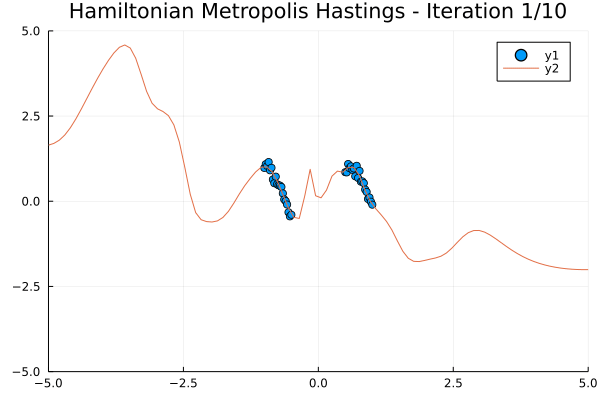

In [3]:
begin
	#Was capable of drawing straight from the posterior, but why are the first two draws really bad?
	plot_in = collect(LinRange(-5, 5, 100))
	plot_in = reshape(plot_in, size(plot_in)..., 1)

	epochs = length(samples)
	anim = @animate for i in range(1, epochs)
		scatter(inputs, targets, xlim=(-5, 5), ylim=(-5, 5), title="Hamiltonian Metropolis Hastings - Iteration $i/$epochs")
		plot!(plot_in, predictions(samples[i], plot_in))
	end
	gif(anim, fps=3)
end

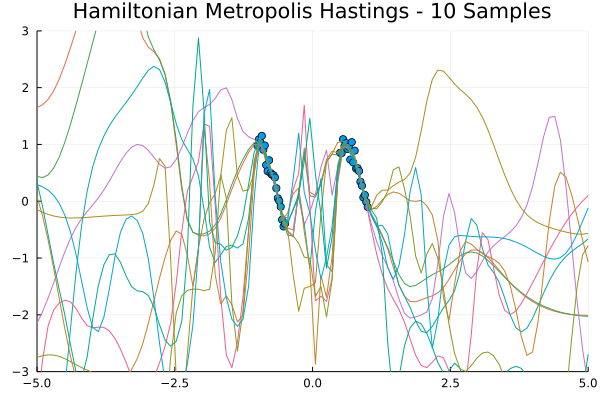

In [4]:
plot_in = collect(LinRange(-5, 5, 100))
plot_in = reshape(plot_in, size(plot_in)..., 1)

epochs = length(samples)
scatter(inputs, targets, xlim=(-5, 5), ylim=(-3, 3), title="Hamiltonian Metropolis Hastings - 10 Samples", label="")
for i in range(1, epochs)
    plot!(plot_in, predictions(samples[i], plot_in), label="")
end
savefig("images/hmc_dataset_1.png")
current()

In [5]:
	# Specify a few constants
	Random.seed!(0)
	mc_samples = 5
	num_weights, predictions, logprob = make_neural_network_functions([1, 20, 20, 1], 0.1, 0.01, rbf)
	inputs, targets = build_toy_dataset_2()
	log_posterior(weights) = logprob(weights, inputs, targets)
	
	# Choose parameter dimensionality and initial parameter value
	D = num_weights
	initial_θ = rand(D)
	
	# Define the target distribution
	ℓπ(θ) = log_posterior(θ)
	
	# Set the number of samples to draw and warmup iterations
	#20 10 showed results
	n_samples, n_adapts = 20, 10
	
	# Define a Hamiltonian system
	metric = DiagEuclideanMetric(D)
	hamiltonian = Hamiltonian(metric, ℓπ, Zygote)
	
	# Define a leapfrog solver, with initial step size chosen heuristically
	initial_ϵ = find_good_stepsize(hamiltonian, initial_θ)
	integrator = Leapfrog(initial_ϵ)
	
	# Define an HMC sampler, with the following components
	#   - multinomial sampling scheme,
	#   - generalised No-U-Turn criteria, and
	#   - windowed adaption for step-size and diagonal mass matrix
	proposal = NUTS{MultinomialTS, GeneralisedNoUTurn}(integrator)
	adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.8, integrator))
	
	# Run the sampler to draw samples from the specified Gaussian, where
	#   - `samples` will store the samples
	#   - `stats` will store diagnostic statistics for each sample
	samples, stats = sample(hamiltonian, proposal, initial_θ, n_samples, adaptor, n_adapts; progress=false, drop_warmup=true);

┌ Info: Finished 10 adapation steps
│   adaptor = StanHMCAdaptor(
    pc=WelfordVar,
    ssa=NesterovDualAveraging(γ=0.05, t_0=10.0, κ=0.75, δ=0.8, state.ϵ=0.0022642722703585015),
    init_buffer=75, term_buffer=50, window_size=25,
    state=window(76, -40), window_splits()
)
│   κ.τ.integrator = Leapfrog(ϵ=0.00226)
│   h.metric = DiagEuclideanMetric([1.0, 1.0, 1.0, 1.0, 1.0, 1 ...])
└ @ AdvancedHMC C:\Users\andre\.julia\packages\AdvancedHMC\51xgc\src\sampler.jl:189
┌ Info: Finished 20 sampling steps for 1 chains in 4.1445027 (s)
│   h = Hamiltonian(metric=DiagEuclideanMetric([1.0, 1.0, 1.0, 1.0, 1.0, 1 ...]))
│   κ = HMCKernel{AdvancedHMC.FullMomentumRefreshment, Trajectory{MultinomialTS, Leapfrog{Float64}, GeneralisedNoUTurn{Float64}}}(AdvancedHMC.FullMomentumRefreshment(), Trajectory{MultinomialTS}(integrator=Leapfrog(ϵ=0.00226), tc=GeneralisedNoUTurn{Float64}(10, 1000.0)))
│   EBFMI_est = 1.8001187621852386
│   average_acceptance_rate = 0.5782133011468111
└ @ AdvancedHMC C:\Users\a

┌ Info: Saved animation to 
│   fn = C:\Users\andre\idea_projects\julia\CS5099\tmp.gif
└ @ Plots C:\Users\andre\.julia\packages\Plots\Ra8fG\src\animation.jl:126


Plots.AnimatedGif("C:\\Users\\andre\\idea_projects\\julia\\CS5099\\tmp.gif")
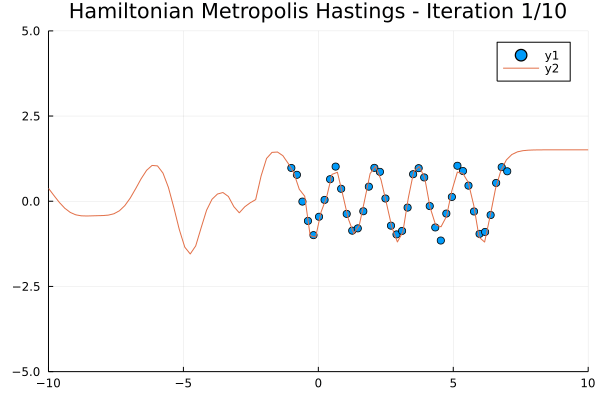

In [6]:
begin
	#Was capable of drawing straight from the posterior, but why are the first two draws really bad?
	plot_in = collect(LinRange(-10, 10, 100))
	plot_in = reshape(plot_in, size(plot_in)..., 1)

	epochs = length(samples)
	anim = @animate for i in range(1, epochs)
		scatter(inputs, targets, xlim=(-10, 10), ylim=(-5, 5), title="Hamiltonian Metropolis Hastings - Iteration $i/$epochs")
		plot!(plot_in, predictions(samples[i], plot_in))
	end
	gif(anim, fps=3)
end

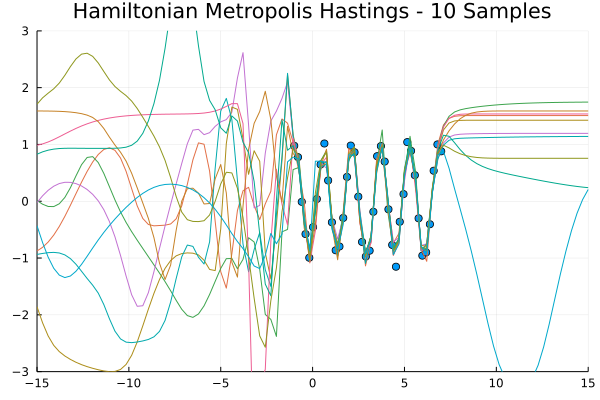

In [7]:
plot_in = collect(LinRange(-15, 15, 100))
plot_in = reshape(plot_in, size(plot_in)..., 1)

epochs = length(samples)
scatter(inputs, targets, xlim=(-15, 15), ylim=(-3, 3), title="Hamiltonian Metropolis Hastings - 10 Samples", label="")
for i in range(1, epochs)
    plot!(plot_in, predictions(samples[i], plot_in), label="")
end
savefig("images/hmc_dataset_2.png")
current()

In [8]:
	# Specify a few constants
	Random.seed!(0)
	mc_samples = 5
	num_weights, predictions, logprob = make_neural_network_functions([1, 20, 20, 1], 0.1, 0.01, rbf)
	inputs, targets = build_toy_dataset_3()
	log_posterior(weights) = logprob(weights, inputs, targets)
	
	# Choose parameter dimensionality and initial parameter value
	D = num_weights
	initial_θ = rand(D)
	
	# Define the target distribution
	ℓπ(θ) = log_posterior(θ)
	
	# Set the number of samples to draw and warmup iterations
	#20 10 showed results
	n_samples, n_adapts = 20, 10
	
	# Define a Hamiltonian system
	metric = DiagEuclideanMetric(D)
	hamiltonian = Hamiltonian(metric, ℓπ, Zygote)
	
	# Define a leapfrog solver, with initial step size chosen heuristically
	initial_ϵ = find_good_stepsize(hamiltonian, initial_θ)
	integrator = Leapfrog(initial_ϵ)
	
	# Define an HMC sampler, with the following components
	#   - multinomial sampling scheme,
	#   - generalised No-U-Turn criteria, and
	#   - windowed adaption for step-size and diagonal mass matrix
	proposal = NUTS{MultinomialTS, GeneralisedNoUTurn}(integrator)
	adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.8, integrator))
	
	# Run the sampler to draw samples from the specified Gaussian, where
	#   - `samples` will store the samples
	#   - `stats` will store diagnostic statistics for each sample
	samples, stats = sample(hamiltonian, proposal, initial_θ, n_samples, adaptor, n_adapts; progress=false, drop_warmup=true);

┌ Info: Finished 10 adapation steps
│   adaptor = StanHMCAdaptor(
    pc=WelfordVar,
    ssa=NesterovDualAveraging(γ=0.05, t_0=10.0, κ=0.75, δ=0.8, state.ϵ=0.0022737153058173653),
    init_buffer=75, term_buffer=50, window_size=25,
    state=window(76, -40), window_splits()
)
│   κ.τ.integrator = Leapfrog(ϵ=0.00227)
│   h.metric = DiagEuclideanMetric([1.0, 1.0, 1.0, 1.0, 1.0, 1 ...])
└ @ AdvancedHMC C:\Users\andre\.julia\packages\AdvancedHMC\51xgc\src\sampler.jl:189
┌ Info: Finished 20 sampling steps for 1 chains in 6.8634918 (s)
│   h = Hamiltonian(metric=DiagEuclideanMetric([1.0, 1.0, 1.0, 1.0, 1.0, 1 ...]))
│   κ = HMCKernel{AdvancedHMC.FullMomentumRefreshment, Trajectory{MultinomialTS, Leapfrog{Float64}, GeneralisedNoUTurn{Float64}}}(AdvancedHMC.FullMomentumRefreshment(), Trajectory{MultinomialTS}(integrator=Leapfrog(ϵ=0.00227), tc=GeneralisedNoUTurn{Float64}(10, 1000.0)))
│   EBFMI_est = 0.2973963015596534
│   average_acceptance_rate = 0.7735901615499784
└ @ AdvancedHMC C:\Users\a

┌ Info: Saved animation to 
│   fn = C:\Users\andre\idea_projects\julia\CS5099\tmp.gif
└ @ Plots C:\Users\andre\.julia\packages\Plots\Ra8fG\src\animation.jl:126


Plots.AnimatedGif("C:\\Users\\andre\\idea_projects\\julia\\CS5099\\tmp.gif")
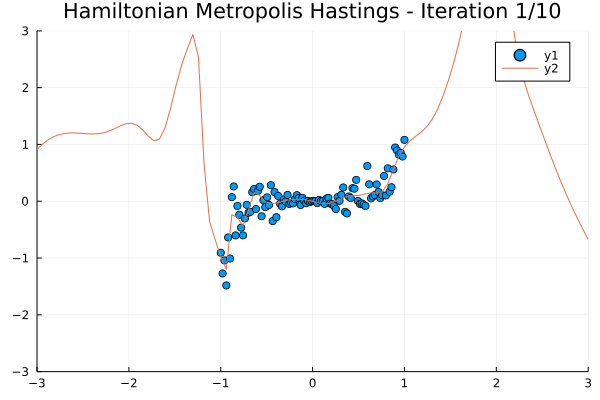

In [9]:
begin
	#Was capable of drawing straight from the posterior, but why are the first two draws really bad?
	plot_in = collect(LinRange(-3, 3, 100))
	plot_in = reshape(plot_in, size(plot_in)..., 1)

	epochs = length(samples)
	anim = @animate for i in range(1, epochs)
		scatter(inputs, targets, xlim=(-3, 3), ylim=(-3, 3), title="Hamiltonian Metropolis Hastings - Iteration $i/$epochs")
		plot!(plot_in, predictions(samples[i], plot_in))
	end
	gif(anim, fps=3)
end

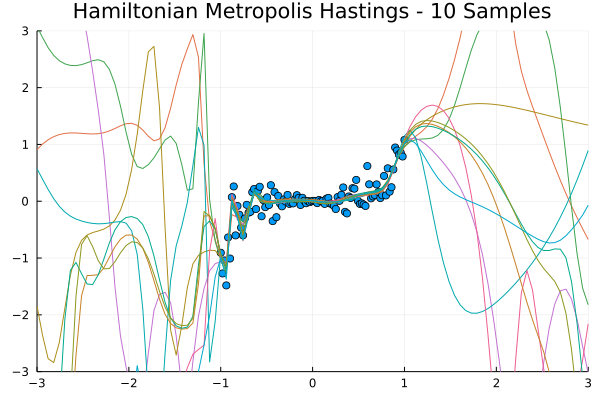

In [10]:
plot_in = collect(LinRange(-3, 3, 100))
plot_in = reshape(plot_in, size(plot_in)..., 1)

epochs = length(samples)
scatter(inputs, targets, xlim=(-3, 3), ylim=(-3, 3), title="Hamiltonian Metropolis Hastings - 10 Samples", label="")
for i in range(1, epochs)
    plot!(plot_in, predictions(samples[i], plot_in), label="")
end
savefig("images/hmc_dataset_3.png")
current()

In [11]:
	# Specify a few constants
	Random.seed!(0)
	mc_samples = 5
	num_weights, predictions, logprob = make_neural_network_functions([1, 20, 20, 1], 0.1, 0.01, rbf)
	inputs, targets = build_toy_dataset_4()
	log_posterior(weights) = logprob(weights, inputs, targets)
	
	# Choose parameter dimensionality and initial parameter value
	D = num_weights
	initial_θ = rand(D)
	
	# Define the target distribution
	ℓπ(θ) = log_posterior(θ)
	
	# Set the number of samples to draw and warmup iterations
	#20 10 showed results
	n_samples, n_adapts = 20, 10
	
	# Define a Hamiltonian system
	metric = DiagEuclideanMetric(D)
	hamiltonian = Hamiltonian(metric, ℓπ, Zygote)
	
	# Define a leapfrog solver, with initial step size chosen heuristically
	initial_ϵ = find_good_stepsize(hamiltonian, initial_θ)
	integrator = Leapfrog(initial_ϵ)
	
	# Define an HMC sampler, with the following components
	#   - multinomial sampling scheme,
	#   - generalised No-U-Turn criteria, and
	#   - windowed adaption for step-size and diagonal mass matrix
	proposal = NUTS{MultinomialTS, GeneralisedNoUTurn}(integrator)
	adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.8, integrator))
	
	# Run the sampler to draw samples from the specified Gaussian, where
	#   - `samples` will store the samples
	#   - `stats` will store diagnostic statistics for each sample
	samples, stats = sample(hamiltonian, proposal, initial_θ, n_samples, adaptor, n_adapts; progress=false, drop_warmup=true);

┌ Info: Finished 10 adapation steps
│   adaptor = StanHMCAdaptor(
    pc=WelfordVar,
    ssa=NesterovDualAveraging(γ=0.05, t_0=10.0, κ=0.75, δ=0.8, state.ϵ=0.0018535925529352567),
    init_buffer=75, term_buffer=50, window_size=25,
    state=window(76, -40), window_splits()
)
│   κ.τ.integrator = Leapfrog(ϵ=0.00185)
│   h.metric = DiagEuclideanMetric([1.0, 1.0, 1.0, 1.0, 1.0, 1 ...])
└ @ AdvancedHMC C:\Users\andre\.julia\packages\AdvancedHMC\51xgc\src\sampler.jl:189
┌ Info: Finished 20 sampling steps for 1 chains in 0.8211924 (s)
│   h = Hamiltonian(metric=DiagEuclideanMetric([1.0, 1.0, 1.0, 1.0, 1.0, 1 ...]))
│   κ = HMCKernel{AdvancedHMC.FullMomentumRefreshment, Trajectory{MultinomialTS, Leapfrog{Float64}, GeneralisedNoUTurn{Float64}}}(AdvancedHMC.FullMomentumRefreshment(), Trajectory{MultinomialTS}(integrator=Leapfrog(ϵ=0.00185), tc=GeneralisedNoUTurn{Float64}(10, 1000.0)))
│   EBFMI_est = 2.9861470225478195
│   average_acceptance_rate = 0.08798354792882947
└ @ AdvancedHMC C:\Users\

┌ Info: Saved animation to 
│   fn = C:\Users\andre\idea_projects\julia\CS5099\tmp.gif
└ @ Plots C:\Users\andre\.julia\packages\Plots\Ra8fG\src\animation.jl:126


Plots.AnimatedGif("C:\\Users\\andre\\idea_projects\\julia\\CS5099\\tmp.gif")
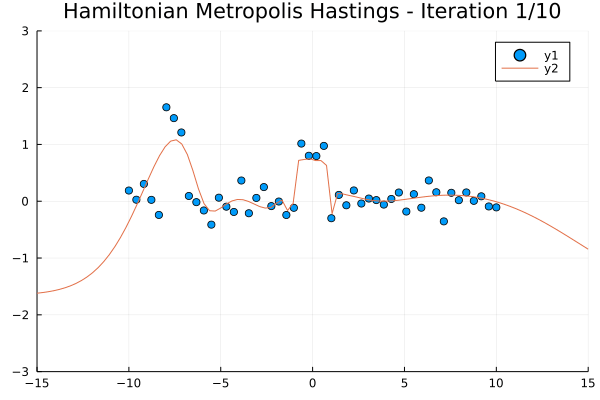

In [12]:
begin
	#Was capable of drawing straight from the posterior, but why are the first two draws really bad?
	plot_in = collect(LinRange(-15, 15, 100))
	plot_in = reshape(plot_in, size(plot_in)..., 1)

	epochs = length(samples)
	anim = @animate for i in range(1, epochs)
		scatter(inputs, targets, xlim=(-15, 15), ylim=(-3, 3), title="Hamiltonian Metropolis Hastings - Iteration $i/$epochs")
		plot!(plot_in, predictions(samples[i], plot_in))
	end
	gif(anim, fps=3)
end

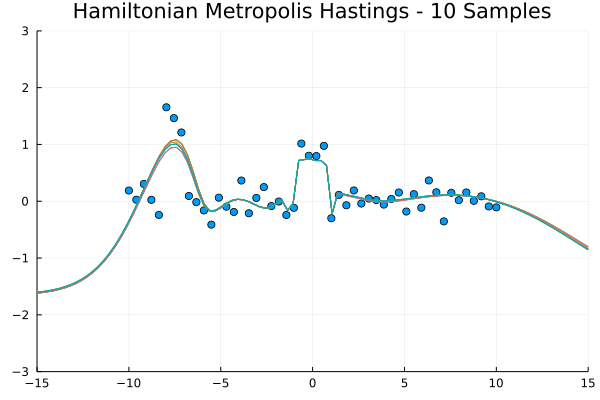

In [13]:
plot_in = collect(LinRange(-15, 15, 100))
plot_in = reshape(plot_in, size(plot_in)..., 1)

epochs = length(samples)
scatter(inputs, targets, xlim=(-15, 15), ylim=(-3, 3), title="Hamiltonian Metropolis Hastings - 10 Samples", label="")
for i in range(1, epochs)
    plot!(plot_in, predictions(samples[i], plot_in), label="")
end
current()

In [14]:
	# Specify a few constants
	Random.seed!(0)
	mc_samples = 5
	num_weights, predictions, logprob = make_neural_network_functions([1, 20, 20, 1], 0.1, 0.01, rbf)
	inputs, targets = build_toy_dataset_4()
	log_posterior(weights) = logprob(weights, inputs, targets)
	
	# Choose parameter dimensionality and initial parameter value
	D = num_weights
	initial_θ = rand(D)
	
	# Define the target distribution
	ℓπ(θ) = log_posterior(θ)
	
	# Set the number of samples to draw and warmup iterations
	#20 10 showed results
	n_samples, n_adapts = 100, 20
	
	# Define a Hamiltonian system
	metric = DiagEuclideanMetric(D)
	hamiltonian = Hamiltonian(metric, ℓπ, Zygote)
	
	# Define a leapfrog solver, with initial step size chosen heuristically
	initial_ϵ = find_good_stepsize(hamiltonian, initial_θ)
	integrator = Leapfrog(initial_ϵ)
	
	# Define an HMC sampler, with the following components
	#   - multinomial sampling scheme,
	#   - generalised No-U-Turn criteria, and
	#   - windowed adaption for step-size and diagonal mass matrix
	proposal = NUTS{MultinomialTS, GeneralisedNoUTurn}(integrator)
	adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.8, integrator))
	
	# Run the sampler to draw samples from the specified Gaussian, where
	#   - `samples` will store the samples
	#   - `stats` will store diagnostic statistics for each sample
	samples, stats = sample(hamiltonian, proposal, initial_θ, n_samples, adaptor, n_adapts; progress=false, drop_warmup=true);

┌ Info: Finished 20 adapation steps
│   adaptor = StanHMCAdaptor(
    pc=WelfordVar,
    ssa=NesterovDualAveraging(γ=0.05, t_0=10.0, κ=0.75, δ=0.8, state.ϵ=0.0008004007919571917),
    init_buffer=75, term_buffer=50, window_size=25,
    state=window(76, -30), window_splits()
)
│   κ.τ.integrator = Leapfrog(ϵ=0.0008)
│   h.metric = DiagEuclideanMetric([1.0, 1.0, 1.0, 1.0, 1.0, 1 ...])
└ @ AdvancedHMC C:\Users\andre\.julia\packages\AdvancedHMC\51xgc\src\sampler.jl:189
┌ Info: Finished 100 sampling steps for 1 chains in 33.4325897 (s)
│   h = Hamiltonian(metric=DiagEuclideanMetric([1.0, 1.0, 1.0, 1.0, 1.0, 1 ...]))
│   κ = HMCKernel{AdvancedHMC.FullMomentumRefreshment, Trajectory{MultinomialTS, Leapfrog{Float64}, GeneralisedNoUTurn{Float64}}}(AdvancedHMC.FullMomentumRefreshment(), Trajectory{MultinomialTS}(integrator=Leapfrog(ϵ=0.0008), tc=GeneralisedNoUTurn{Float64}(10, 1000.0)))
│   EBFMI_est = 0.18304162210196276
│   average_acceptance_rate = 0.9420025446002693
└ @ AdvancedHMC C:\Users\